# K-Means Clustering and Segementation - Global (non-UK) Customers

In this notebook, we apply machine learning techniques to segment customers into meaningful groups based on their purchasing behavior. We'll be using the RFM (Recency, Frequency, Monetary) features previously generated in data preparation step, to identify a reasonable number of clusters seperately for Domestic (UK) and Global (non-UK) markets. The business objective is to then identify meaningful customer segments such as VIP customers, loyal regulars, at-risk buyers for each of the two (Domestic and Global) markets. These insights will support data-driven marketing and retention strategies.

**NOTE**: In this notebook, we'll use the prepared RFM dataset for the **Global (non-UK) Customers** (previously generated in the 'EDA' notebook).

<!-- 
**Contents**

0. Import packages and set reproducibility options
1. Loading RFM data 
2. Data overview 
3. Feature transforming and scaling 
4. K-Means clustering: Finding optimal number of clusters (k) 
5. K-Means clustering: Model training and cluster assignment 
6. Interprtation: Cluster profiles and segment labels 
7. Cluster visualizations 
8. Insights -- move to sperate notebook or README.md

-->

## 0 - Package Imports

In [1]:
%load_ext dotenv
%dotenv

# Import necessary libraries
import os
import sys
from pathlib import Path

import datetime as dt
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes

# Set package options
np.random.seed(42)                  # set random seed for reproducibility
sns.set_theme(style="whitegrid")    # set seaborn style
set_config(transform_output='pandas')

In [2]:
# Load plot style source file
sys.path.append(str(Path.cwd().parent / "src"))

from plot_style import setup, COLORS, style_ax
setup()


## 1 - Loading RFM dataset

The previously cleaned and pre-processed RFM dataset is loaded. This dataset contains one row per customer with their Recency (R), Frequency (F) and Monetary (M) values. These numeric features will form the inputs to the customer clustering models. We'll split the full dataset into Domestic (UK) and International (non-UK) customers, and clustering for each split. We'll be using the Scikit Learn's K-Means implementation for clustering. 

In [3]:
# Load the prepared RFM data into a pandas dataframe
rfm = pd.read_csv('../data/prepared/rfm_international.csv')

# Display the top rows
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region
0,12347,1,7,4310.00,Iceland,International
1,12348,74,4,1797.24,Finland,International
2,12349,18,1,1757.55,Italy,International
3,12350,309,1,334.40,Norway,International
4,12352,35,8,2506.04,Norway,International


In [4]:
# Check shape of dataframe
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       421 non-null    int64  
 1   Recency          421 non-null    int64  
 2   Frequency        421 non-null    int64  
 3   Monetary         421 non-null    float64
 4   Country          421 non-null    object 
 5   Customer_Region  421 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 19.9+ KB


In [5]:
# Display summary statistics for the dataset
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,421.000000,421.000000,421.000000,421.000000
mean,12822.973872,93.251781,4.570071,3853.897268
std,863.209061,104.264559,11.337378,17556.881606
min,12347.000000,0.000000,1.000000,51.560000
25%,12468.000000,18.000000,1.000000,459.400000
50%,12599.000000,51.000000,2.000000,1053.490000
75%,12725.000000,130.000000,5.000000,2780.660000
max,17844.000000,373.000000,201.000000,280206.020000


## 2 - Data Overview 

The full dataset has 4,341 customers (each given by `CustomerID`) and three numeric features to be used for clustering: 
* `Recency`: Days elapsed since last purchase relative to the reference date (lower is good -> more recent customer) 
* `Frequency`: Total number of purchases (higher is good -> more loyal customer) 
* `Monetary`: Total purchase revenue (higher is good -> more valuable customer) 

Additionally, feature `Country` or `Country_Region` is used to split the dataset is into seperate sub-datasets for domestics (UK) and international (non-UK) customers. 

We can see from above summary statistics that the numeric features have high variability and on widely-differing scales. Further, we can visualize the skeweness in RFM features below. 

In [6]:
# Function to visualize RFM distributions
def plot_rfm_distributions(rfm_data, title_suffix='', bins=30, colors=None):
    if colors is None:
        colors = {'recency': 'skyblue', 'frequency': 'salmon', 'monetary': 'lightgreen'}
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(rfm_data['Recency'], bins=bins, kde=True, ax=axes[0], color=colors['recency'])
    axes[0].set_title(f'Recency Distribution {title_suffix}')
    axes[0].set_xlabel('Recency (nr. of days)')
    sns.histplot(rfm_data['Frequency'], bins=bins, kde=True, ax=axes[1], color=colors['frequency'])
    axes[1].set_title(f'Frequency Distribution {title_suffix}')
    axes[1].set_xlabel('Frequency (nr. of invoices)')
    sns.histplot(rfm_data['Monetary'], bins=bins, kde=True, ax=axes[2], color=colors['monetary'])
    axes[2].set_title(f'Monetary Distribution {title_suffix}')
    axes[2].set_xlabel('Monetary (spending value, GBP)')

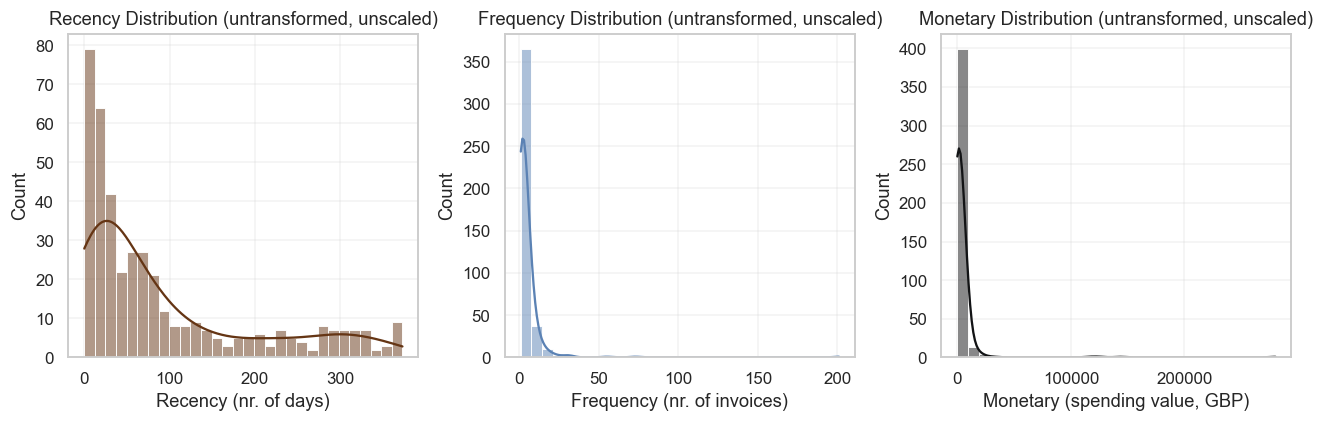

In [7]:
# Visualize RFM frequencies for untranformed, unscaled data
plot_rfm_distributions(rfm, title_suffix='(untransformed, unscaled)', colors=COLORS)
plt.tight_layout()
plt.savefig("../reports/modeling/fig__rfm_unscaled__dist__global.png", dpi=150, bbox_inches="tight")
plt.show()

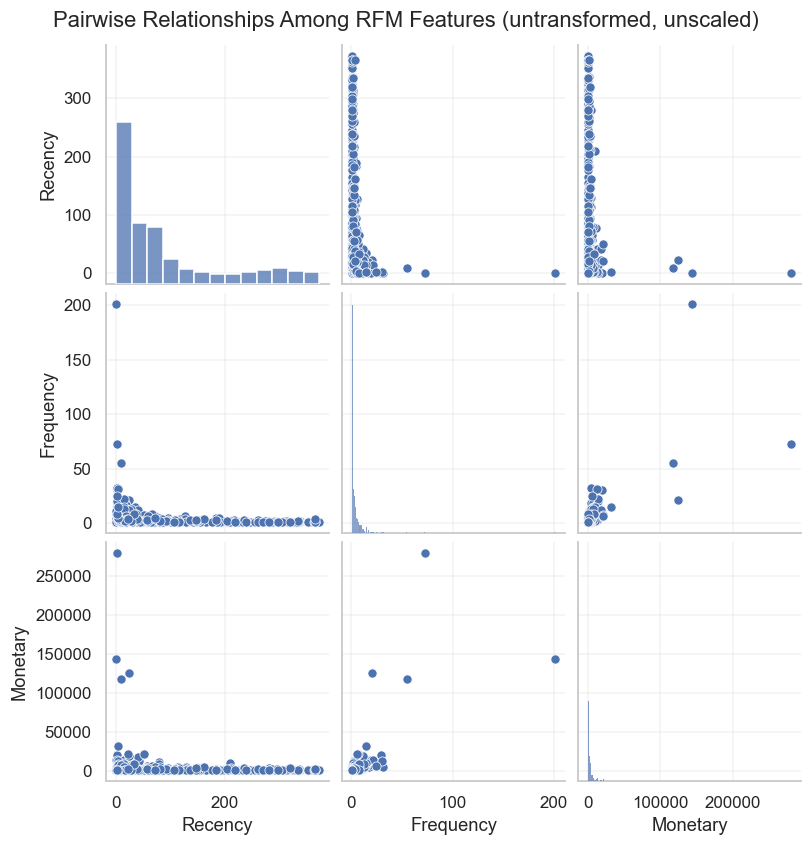

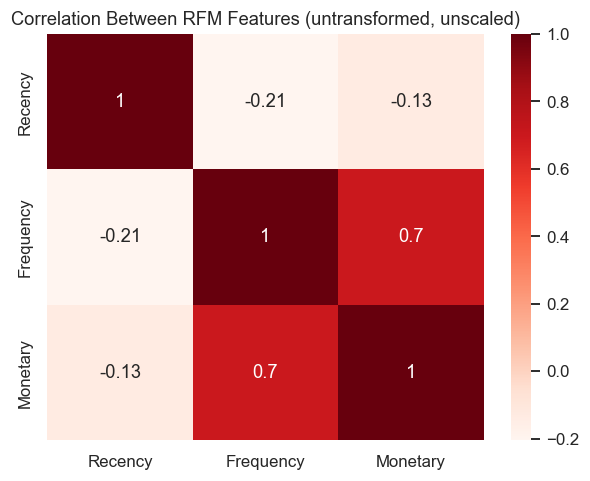

In [8]:
# Plot a heatmap and pairplot to visualize pair-wise relationships between features
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.suptitle('Pairwise Relationships Among RFM Features (untransformed, unscaled)', y=1.02)
plt.savefig("../reports/modeling/fig__rfm_unscaled__pairplot__global.png", dpi=150, bbox_inches="tight")
plt.show()

sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='Reds')
plt.title('Correlation Between RFM Features (untransformed, unscaled)')
plt.savefig("../reports/modeling/fig__rfm_unscaled__heatmap__global.png", dpi=150, bbox_inches="tight")
plt.show()

**Data Overview: Summary**

>*Distributions*: The above visualizations help us understand how each RFM feature is distributed, and confirm that the RFM features are highly skewed and are on widely different scales. Each feature (Recency, Frequency, and Monetary) distribution is skewed right. 
> 
>*Correlations*: Recency is negatively correlated with both Frequency and Monetary features. There appears to be a weak positive correlation between Frequency and Monetary. Customer who have more recent purchases don't have frequent or high-revenue purchases. 
> 
>Before applying K-Means, we have explored the RFM features to understand their distributions, correlations, and outliers. The data shows a typical right-skewed pattern common in customer behavior datasets, with strong links between Frequency and Monetary values. These findings guide preprocessing steps such as scaling and transformation to ensure fair contribution of all features in clustering.

## 3 - Transforming and Scaling Features

During the inspection of the RFM dataset, several issues were identified that required feature transformation and scaling before applying K-Means clustering. The RFM variables are measured on different scales and exhibit significant skewness, which can distort distance-based clustering results. 

To address this, we apply the **log1p transformation** (natural log of x + 1) to reduce skewness and normalize feature distributions. Next, we use `StandardScaler` from `sklearn.preprocessing` to standardize the features so that each has a mean of 0 and a standard deviation of 1. Since K-Means relies on Euclidean distance, unscaled features (for example, Monetary in thousands versus Frequency in single digits) can disproportionately influence the clustering process. Scaling ensures that all RFM dimensions contribute equally to the distance calculations, resulting in more balanced and meaningful clusters.

In [9]:
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Apply log transformation to RFM metrics to reduce skewness
rfm_log = rfm_features.apply(lambda x: np.log1p(x))
print(f'After log-transformation: \n', rfm_log.describe())

After log-transformation: 
           Recency   Frequency    Monetary
count  421.000000  421.000000  421.000000
mean     3.777608    1.349791    7.058410
std      1.430050    0.695497    1.302681
min      0.000000    0.693147    3.961955
25%      2.944439    0.693147    6.132096
50%      3.951244    1.098612    6.960813
75%      4.875197    1.791759    7.930803
max      5.924256    5.308268   12.543284


In [10]:
# Standardize the log-transformed RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
#rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(f'After scaling: \n', rfm_scaled.describe())

After scaling: 
             Recency     Frequency      Monetary
count  4.210000e+02  4.210000e+02  4.210000e+02
mean  -4.219375e-18 -2.890272e-16  5.727801e-16
std    1.001190e+00  1.001190e+00  1.001190e+00
min   -2.644735e+00 -9.452603e-01 -2.379814e+00
25%   -5.833085e-01 -9.452603e-01 -7.119292e-01
50%    1.215639e-01 -3.615803e-01 -7.500986e-02
75%    7.684316e-01  6.362274e-01  6.704870e-01
max    1.502886e+00  5.698354e+00  4.215459e+00


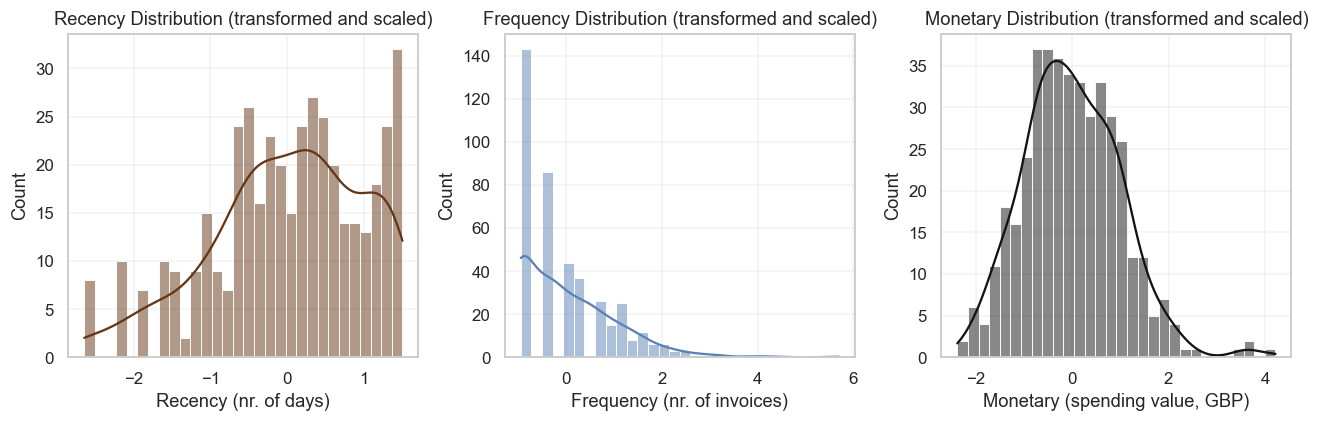

In [11]:
# Visualize RFM distributions for log-transformed and scaled data
plot_rfm_distributions(rfm_scaled, title_suffix='(transformed and scaled)', colors=COLORS)
plt.tight_layout()
plt.savefig("../reports/modeling/fig__rfm_scaled__dist__global.png", dpi=150, bbox_inches="tight")
plt.show()

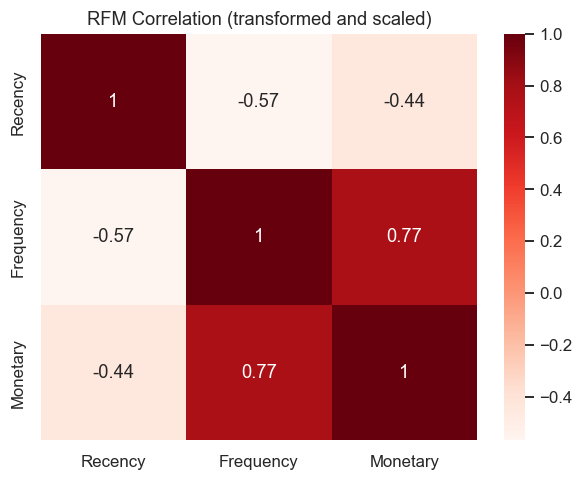

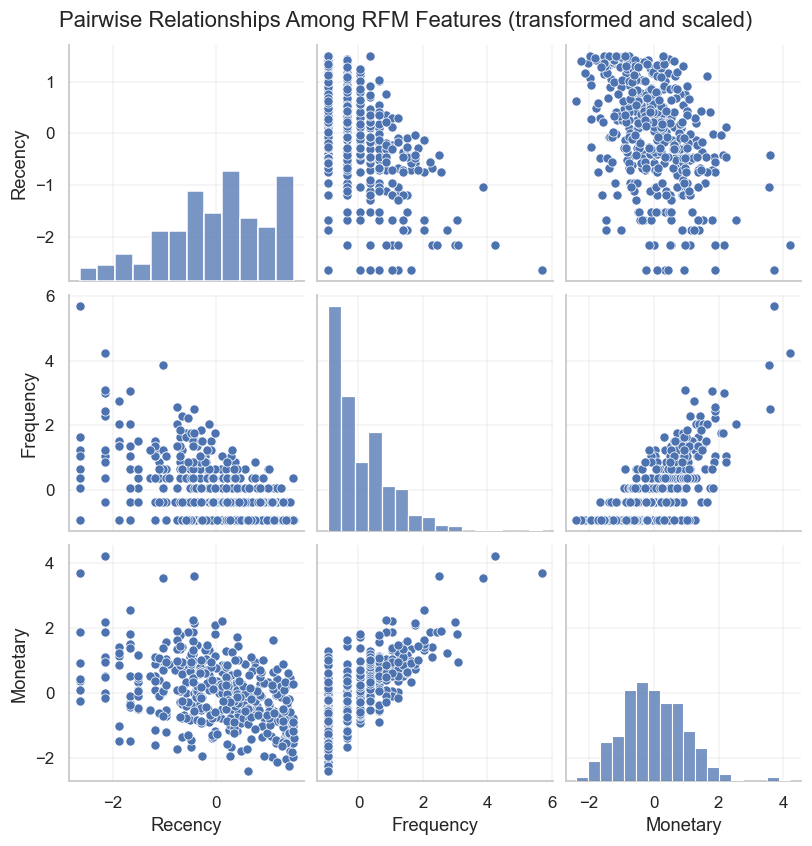

In [12]:
# Plot a correlation heatmap for RFM (transformed and scaled)
sns.heatmap(rfm_scaled[['Recency','Frequency','Monetary']].corr(), annot=True, cmap='Reds')
plt.title("RFM Correlation (transformed and scaled)")
plt.savefig("../reports/modeling/fig__rfm_scaled__heatmap__global.png", dpi=150, bbox_inches="tight")
plt.show()


# Plot pairwise plot for RFM (transformed and scaled) data
sns.pairplot(rfm_scaled[['Recency','Frequency','Monetary']])
plt.suptitle('Pairwise Relationships Among RFM Features (transformed and scaled)', y=1.02)
plt.savefig("../reports/modeling/fig__rfm_scaled__pairplot__global.png", dpi=150, bbox_inches="tight")
plt.show()

**Feature Transformation and Scaling: Summary** 

>The features have been transformed to reduce skewness and standardized to prepare for clustering. Each RFM feature now has a mean of zero and a unit variance, ensuring all features contribute equally during K-Means clustering. `Recency` has as moderate negative correlation with `Frequency` and `Monetary`. `Frequency` and `Monetary` show a strong postive correlation. 

## 4 - *K-Means* Clustering: Finding Optimal Number of Clusters (*k*)

Since the number of clusters in the dataset is not known beforehand, we take an iterative approach by applying the K-Means algorithm across a range of k values (from 2 to 10). 

We then evaluate the clustering performance using the Elbow method (plotting inertia against k) to identify the point where adding more clusters offers diminishing returns.

Additionally, we can evalute cluster stability by visualizing the Silhouette Score, where higher values indicate better-defined and more cohesive clusters.

In [13]:
inertia_scores = []       # Sum of Squres Error's for various k values (WSSD's)
silhouette_scores = []    # Silhouette scores for various k values

k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans = kmeans.fit(rfm_scaled)
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Display the scores for each model
clusters = pd.DataFrame({'k-value': k_range, 'inertia score': inertia_scores, 'silhouette score': silhouette_scores})
clusters

c:\Users\bisha\miniconda3\envs\dsi_participant\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\bisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a me

,k-value,inertia score,silhouette score
0,2,649.537148,0.429441
1,3,511.984575,0.314515
2,4,415.758966,0.316479
3,5,344.269760,0.309797
4,6,297.333362,0.303221
5,7,263.851222,0.293896
6,8,238.932850,0.298769
7,9,222.404763,0.291969
8,10,204.202182,0.276555


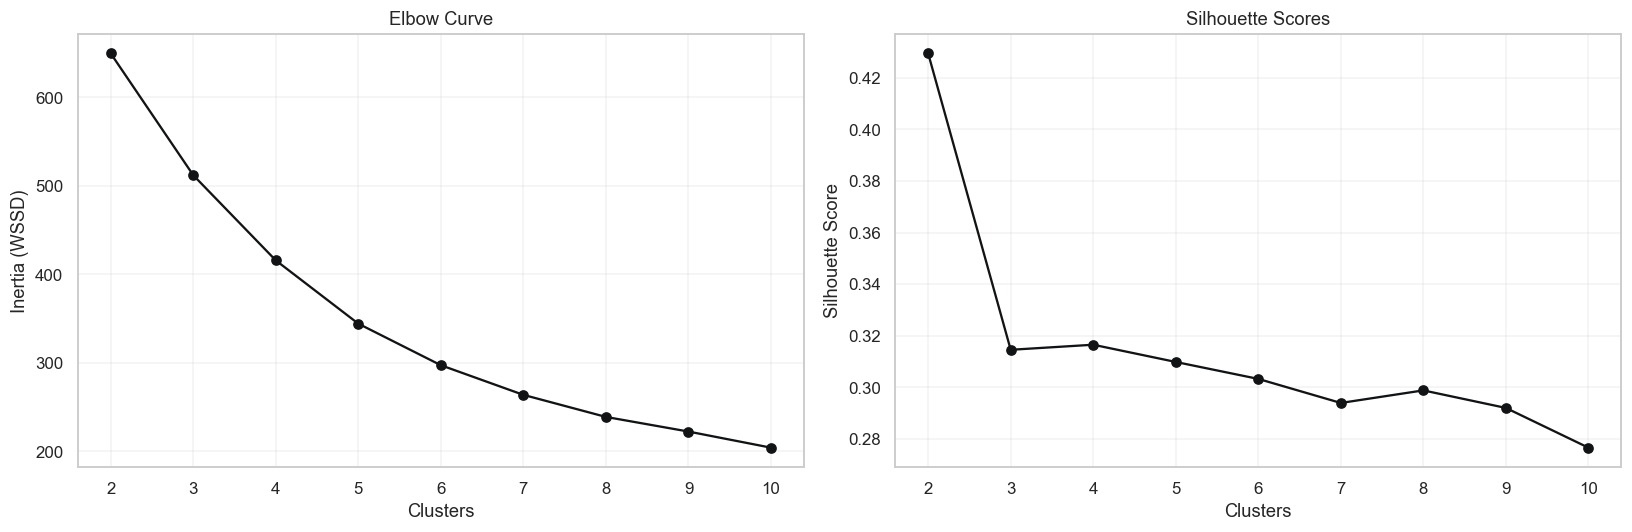

In [14]:
# Plot the Elbow curve for the range of k values
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(k_range, inertia_scores, marker='o', color=COLORS['elbow'])
plt.title("Elbow Curve")
plt.xlabel("Clusters")
plt.ylabel("Inertia (WSSD)")

plt.subplot(1,2,2)
plt.plot(k_range, silhouette_scores, marker='o', color=COLORS['elbow'])
plt.title("Silhouette Scores")
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.savefig("../reports/modeling/fig__elbow-silhouette__global.png", dpi=150, bbox_inches="tight")
plt.show()

**Finding Optimal Clusters: Summary**

>The Elbow Method plot shows how cluster compactness improves as K increases. The “bend” or “elbow” in the curve represents a good candidate for the number of clusters and beyond that point, additional clusters bring diminishing returns. The Silhouette Score measures how well each customer fits within its assigned cluster compared to others. A higher average silhouette score indicates better-defined clusters. The optimal K usually aligns with both a visible elbow in the previous plot and a local maximum here. 
>
>Looking at the above visualizations, we can say that **the optimal number of clusters is _4_**. 

## 5 - Final Model Training and Cluster Assignment

Now that we have determined the optimal number of clusters (*k = 4*) using the Elbow method above, we will train the our final K-Means clustering model. This will seperate the dataset into as distinct clusters. In this case, the model will seperate the dataset into four clusters. Each customer will then be assigned to one clusters, allowing us to later identify distinct behavioural customer segments based on their ranking on an RFM profile. (Explore this in more detail, and sperate key points). 

In [15]:
# Set optimal value for k
optimal_k = 4

# Train the final K-Mean clustering model for optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_final.fit_predict(rfm_scaled)

# Assign cluster label to each customer
#rfm_scaled['Cluster'] = kmeans_final.labels_
rfm['Cluster'] = kmeans_final.labels_

# See sample of clusterd customers
rfm.head()

c:\Users\bisha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region,Cluster
0,12347,1,7,4310.00,Iceland,International,0
1,12348,74,4,1797.24,Finland,International,2
2,12349,18,1,1757.55,Italy,International,3
3,12350,309,1,334.40,Norway,International,1
4,12352,35,8,2506.04,Norway,International,2


In [16]:
# Save clustered dataset to disk as CSV
rfm.to_csv(f'../data/prepared/rfm_domestic_clustered_final_k_{optimal_k}.csv', index=False)

**Final Model Training and Cluster Assigment: Summary**

>Each customer is now assigned to a unique cluster (0, 1, 2, 3), based on the similar purchasing behaviours in terms of recency, frequence and monetary features. The final cluster assignments are saved to disk in a CSV file for further analysis and business inerpretation. 

## 6 - Interprtation: Cluster Profiles and Segment Labels 

<!-- _Approach 1_: This is mapping business-focused segements to the already identified clusters in the data. -->
To interpret clusters meaningfully in the business context, we first calculate summary statistics (mean or median) for Recency, Frequency, and Monetary values grouped by each cluster. This helps us understand how each group/cluster of customers behaves in terms of purchaing behaviour, i.e., whether it contains recent, frequent, or high-spending customers. This lets us map the clusters in the data to business-oriented customer segements.

<!-- This is a manual rule based approach. -->
<!-- 
_Approach 2_: In this approach, we'll assign each customer scores from 1–5 for each of Recency, Frequency, and Monetary value using quantile-based ranking. Lower Recency indicates more recent purchases and thus a higher score, while higher Frequency and Monetary values reflect greater engagement and spending. The quantile-based approach ensures scores are data-driven and comparable across metrics. The combined RFM_Score and behavioral Segment labels (e.g., Champions, At Risk) help identify key customer groups for targeted marketing and retention strategies. 
-->

In [17]:
# Score clusters, identify business segments and map to clusters

# Create a cluster profile based on RFM aggreates by cluster

#cluster_stats = rfm.groupby('Cluster').agg({'Recency':'median','Frequency':'median','Monetary':'median'})
cluster_stats = (rfm.groupby('Cluster')
                 .agg({'Recency':'mean','Frequency':'mean','Monetary':'mean', 'CustomerID': 'count'}).round(2)
                ).rename(columns={'CustomerID': 'CustomerID_count'})

# Business rules: low recency is good - high frequency is good - high monetary is good (R, F, M score is [1, 4])
cluster_stats['Recency_score'] = cluster_stats['Recency'].rank(ascending=False, method='min').astype(int)       # lower  = better score
cluster_stats['Frequency_score'] = cluster_stats['Frequency'].rank(ascending=True, method='min').astype(int)    # higher = better score
cluster_stats['Monetary_score'] = cluster_stats['Monetary'].rank(ascending=True, method='min').astype(int)      # higher = better score

cluster_stats['Cluster_score'] = (cluster_stats['Recency_score'] + cluster_stats['Frequency_score'] + cluster_stats['Monetary_score'])

# Sort clusters by rank
cluster_stats = cluster_stats.sort_values('Cluster_score', ascending=False)    # higher is good
cluster_stats

,Recency,Frequency,Monetary,CustomerID_count,Recency_score,Frequency_score,Monetary_score,Cluster_score
Cluster,,,,,,,,
0,12.73,14.42,14784.55,79,4,4,4,12
2,71.15,3.62,2625.45,124,2,3,3,8
3,16.08,2.04,679.36,71,3,2,2,7
1,192.44,1.30,549.12,147,1,1,1,3


To make results actionable for business stakeholders and align the interpretation with our business focus, we'll assign intuitive business-oriented labels for customer segments, as follows: 

In [18]:
# Review the above cluster summary and apply appropriate segment labels
def assign_segment(row):
    r, f, m = row['Recency_score'], row['Frequency_score'], row['Monetary_score']

    if r >= 4 and f >= 4 and m >= 4:
        return 'VIP / Champions'
    elif r == 2 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f <= 2 and m <= 2:
        return 'Potential Loyalists'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'At-Risk'
    else:
        return 'At-Risk'  # fallback

cluster_stats['Segment_Label'] = cluster_stats.apply(assign_segment, axis=1)
cluster_stats

,Recency,Frequency,Monetary,CustomerID_count,Recency_score,Frequency_score,Monetary_score,Cluster_score,Segment_Label
Cluster,,,,,,,,,
0,12.73,14.42,14784.55,79,4,4,4,12,VIP / Champions
2,71.15,3.62,2625.45,124,2,3,3,8,Loyal Customers
3,16.08,2.04,679.36,71,3,2,2,7,Potential Loyalists
1,192.44,1.30,549.12,147,1,1,1,3,At-Risk


In [19]:
# Finally, apply cluster-corresponding segment labels to customers
cluster_labels = {
    2: 'VIP / Champions',
    1: 'Loyal Customers',
    0: 'Potential Loyalists',
    3: 'At-Risk'
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)
rfm.head()

# Save cluster and segment dataset to disk as CSV
rfm.to_csv(f'../data/prepared/rfm_domestic_clustered_segmented_final_k_{optimal_k}.csv', index=False)

| Cluster # | Cluster Behaviour (R, F, M)                     | Customer Buying Behaviour                | Segment Label           | Recommendation                  |
|------------|-------------------------------------------------|-----------------------------------------|------------------------|----------------------------------|
| 2          | Low Recency (10.57), High Frequency (13.90), High Monetary (8205.16) | Recent, frequent, high-spending         | **VIP / Champions**    | Offer exclusive rewards and premium perks |
| 1          | Moderate Recency (67.97), Moderate Frequency (4.18), Moderate Monetary (1821.35) | Moderately active, mid-spending         | **Loyal Customers**    | Encourage repeat purchases with loyalty programs |
| 0          | Low Recency (16.94), Low Frequency (2.12), Low Monetary (541.55) | Recently active, showing growth potential | **Potential Loyalists**| Targeted offers to boost activity |
| 3          | High Recency (179.83), Very Low Frequency (1.32), Low Monetary (345.30) | Inactive or slipping customers          | **At-Risk**            | Run win-back campaigns and re-engagement emails |


**Cluster Profiles and Segment Labels: Summary**

> These business-friendly labels make the clustering insights easier to communicate to marketing and management teams. The specific cluster to segment mapping was validated after reviewing the summary statistics.
>
> Based on the RFM cluster analysis, actionable strategies can be derived for each segment:
>- **VIP / Champions (Cluster 2):** High-value, frequent buyers who should be rewarded with exclusive offers and premium perks to maintain loyalty.  
>- **Loyal Customers (Cluster 1):** Show moderate engagement and spending, so targeted loyalty programs and personalized recommendations can encourage repeat purchases.  
>- **Potential Loyalists (Cluster 0):** Recently interacted but with lower frequency and spending; they can be nurtured with targeted promotions or product suggestions to increase engagement.  
>- **At-Risk Customers (Cluster 3):** Show high recency and low activity, indicating disengagement, and should be targeted with win-back campaigns, discounts, or reminders to re-engage them.

## 7 - Cluster Visualizations

Visualizing the clusters will help us see and confirm whether the clusters are distinct and interpretable. We’ll use a 3D scatter plot in the RFM space, 2D scatter plot (via PCA for dimensionality reduction) and boxplots to compare cluster-level feature distributions.

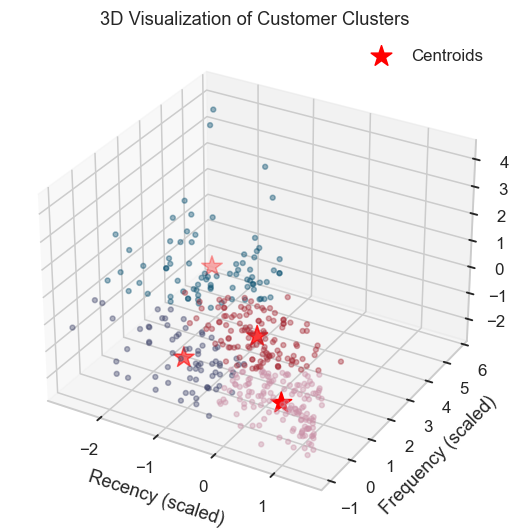

In [20]:
# Function to visualize clusters in 3D space
def plot_3d_clusters(rfm_data, rfm_scaled_data, kmeans_model, colors=None):
    '''Visualize clusters in 3D space
    Parameters:
        rfm_data (DataFrame): Original RFM DataFrame with cluster labels
        rfm_scaled_data (DataFrame): Scaled RFM DataFrame
        kmeans_model (KMeans): Fitted KMeans model
    Returns:
        None
    '''
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.colors import ListedColormap

    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(111, projection='3d')

    cmap = 'viridis' if colors is None else ListedColormap(colors)

    scatter = ax.scatter(
        rfm_scaled_data['Recency'],
        rfm_scaled_data['Frequency'],
        rfm_scaled_data['Monetary'],
        c=rfm_data['Cluster'],
        cmap=cmap,
        s=10,
        alpha=0.4
    )

    # Plot cluster centers
    centers = kmeans_model.cluster_centers_
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        c='red',
        s=200,
        marker='*',
        label='Centroids'
    )

    ax.set_title('3D Visualization of Customer Clusters')
    ax.set_xlabel('Recency (scaled)')
    ax.set_ylabel('Frequency (scaled)')
    ax.set_zlabel('Monetary (scaled)')
    ax.legend()

# Visualize clusters vs. Recency, Frequency and Monetary features in 3D
colors = [
    COLORS['cluster01'],
    COLORS['cluster02'],
    COLORS['cluster03'],
    COLORS['cluster04']
]
plot_3d_clusters(rfm, rfm_scaled, kmeans_final, colors)
plt.tight_layout()
plt.savefig("../reports/modeling/fig__clusters-3d__global.png", dpi=150, bbox_inches="tight")
plt.show()

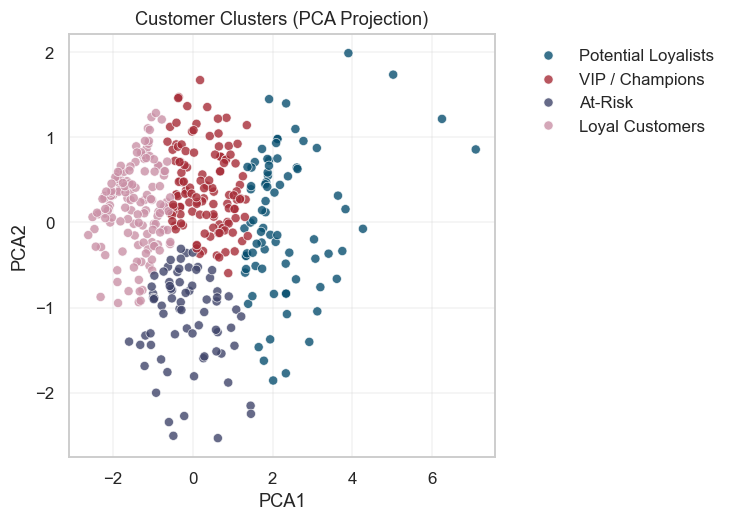

In [21]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

type(pca_components)
rfm['PCA1'] = pca_components.iloc[:, 0]
rfm['PCA2'] = pca_components.iloc[:, 1]

seg_colors = {
    'VIP / Champions': COLORS['cluster03'],
    'Loyal Customers': COLORS['cluster02'],
    'Potential Loyalists': COLORS['cluster01'],
    'At-Risk': COLORS['cluster04']
}

plt.figure(figsize=(5,5))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Segment', palette=seg_colors, alpha=0.8)
plt.title('Customer Clusters (PCA Projection)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("../reports/modeling/fig__clusters-2d-proj__global.png", dpi=150, bbox_inches="tight")
plt.show()

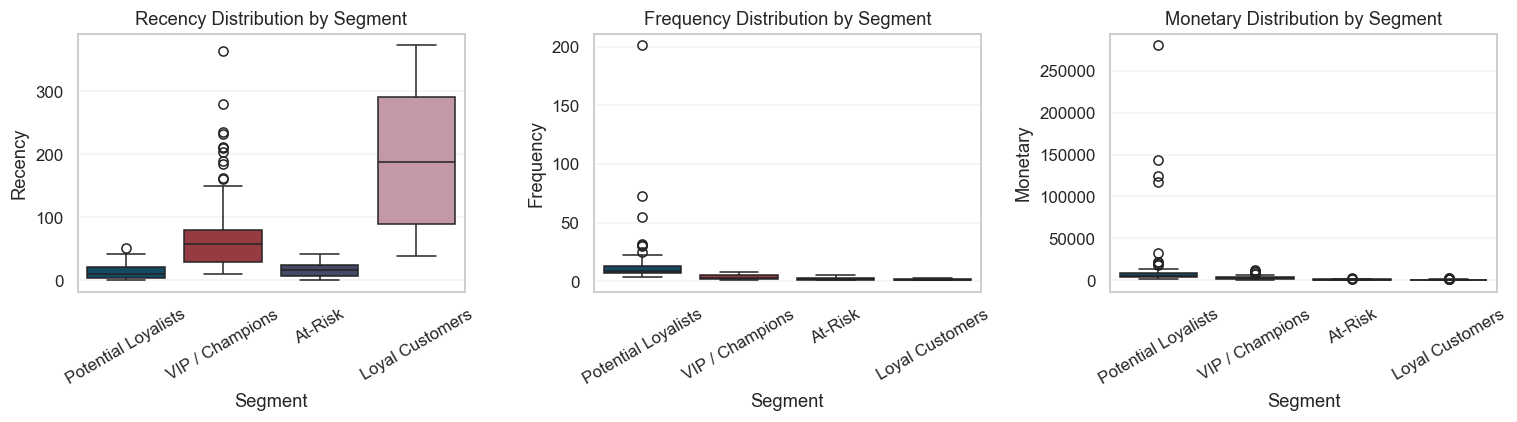

In [22]:
# Box plots for RFM features by cluster / segment
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(data=rfm, x='Segment', hue='Segment', y=col, ax=axes[i], palette=seg_colors, legend=False)
    axes[i].set_title(f'{col} Distribution by Segment')
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig("../reports/modeling/fig__rfm-boxplot-by-cluster__global.png", dpi=150, bbox_inches="tight")
plt.show()